<center><img src="https://miro.medium.com/v2/resize:fit:896/1*4atR_wq8Wk4J4Z7JejfkCQ.png" style="width: 500px"/></center>
<center><font size = 6.5><b>Car Detection Model using FasterCNN ResNet50 FPN</b></font></center>
<center><font size = 4><b>Computer Vision Output</b></font></center>
<br />
<center><font size = 4>Peter Angelo C. Dantes</font></center>
<center><font size = 4>Applied Data Science with Python</font></center>

### **Loading the Dataset**

The dataset contains media of cars in all views and is divided into the following subfolders:

- `Training Images`
- `Testing Images`

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-object-detection


In [3]:
for root, dirs, files in os.walk(path):
    print(root)
    for d in dirs:
        print("  -", d)
    break

/kaggle/input/car-object-detection
  - data


### Loading the data into local variables

In [6]:
dataset_path = "/kaggle/input/car-object-detection/data"
testing_dir = os.path.join(dataset_path, "testing_images")
training_dir = os.path.join(dataset_path, "training_images")
bounding_boxes = os.path.join(dataset_path, "train_solution_bounding_boxes (1).csv")

### Splitting data into train and validation sets

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(bounding_boxes)

all_images = df['image'].unique()
train_files, val_files = train_test_split(
    all_images,
    test_size=0.20,
    random_state=42
)

train_df = df[df['image'].isin(train_files)]
val_df   = df[df['image'].isin(val_files)]

train_df.to_csv('train_annots.csv', index=False)
val_df.to_csv('val_annots.csv',   index=False)

print(f"Training images: {len(train_files)}, Validation images: {len(val_files)}")

Training images: 284, Validation images: 71


### Data Loading

Before building the model, we first have to define how the images will be loaded from the dataset. Additionally, `bounding boxes` are used to define the images from the training dataset.

In [13]:
from torch.utils.data import DataLoader

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import functional as F

class CarDetectionDataset(Dataset):
    def __init__(self, images_dir, annotations_csv, transforms=None):
        self.images_dir = images_dir
        self.df = pd.read_csv(annotations_csv)
        self.image_files = self.df['image'].unique().tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        records = self.df[self.df['image'] == img_name]
        boxes = records[['xmin','ymin','xmax','ymax']].values.astype(float)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        img_id = torch.tensor([idx])
        area   = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd= torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes":    boxes,
            "labels":   labels,
            "image_id": img_id,
            "area":     area,
            "iscrowd":  iscrowd
        }

        img_tensor = F.to_tensor(img)
        if self.transforms:
            img_tensor, target = self.transforms(img_tensor, target)

        return img_tensor, target

dataset_path  = "/kaggle/input/car-object-detection/data"
training_dir  = os.path.join(dataset_path, "training_images")

train_csv     = "train_annots.csv"
val_csv       = "val_annots.csv"

train_dataset = CarDetectionDataset(images_dir=training_dir, annotations_csv=train_csv)
val_dataset   = CarDetectionDataset(images_dir=training_dir, annotations_csv=val_csv)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=lambda b: tuple(zip(*b)))
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, collate_fn=lambda b: tuple(zip(*b)))


<center><img src="https://tryolabs.com/assets/blog/2018-01-18-faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/2018-01-18-faster-rcnn-7e3487b93c.png" style="width: 500px"/></center>

# **Model Building**

We will be using the `Faster R-CNN` model from the `torchvision` pre-trained models. The classifiers for the model will be set to two: [1] `background` and [2] `car`.

The model will be optimized using a `Stochastic Gradient Descent` optimizer with a learning rate of `0.005`.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 4.9107
Epoch 1/5  Train Loss: 12.5750  Val Loss:   4.9107
Validation Loss: 4.7930
Epoch 2/5  Train Loss: 7.4058  Val Loss:   4.7930
Validation Loss: 4.8485
Epoch 3/5  Train Loss: 6.4586  Val Loss:   4.8485
Validation Loss: 4.6243
Epoch 4/5  Train Loss: 5.3949  Val Loss:   4.6243
Validation Loss: 4.6076
Epoch 5/5  Train Loss: 5.0463  Val Loss:   4.6076


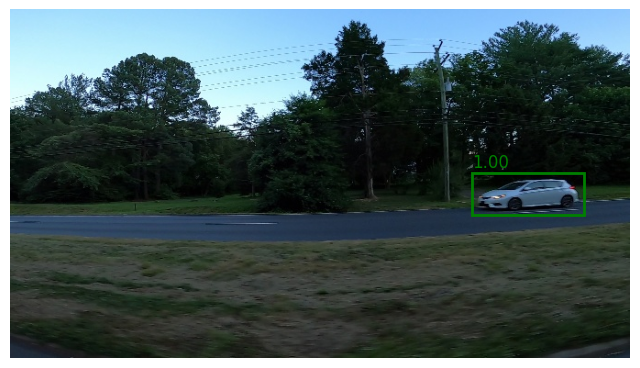

In [15]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

model = fasterrcnn_resnet50_fpn(pretrained=True)

in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_feats, num_classes=2
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    for images, targets in train_loader:

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    val_loss = 0.0
    model.train()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            val_loss += sum(loss for loss in loss_dict.values()).item()

    print(f"Validation Loss: {val_loss:.4f}")

    print(
        f"Epoch {epoch+1}/{num_epochs}  "
        f"Train Loss: {train_loss:.4f}  "
        f"Val Loss:   {val_loss:.4f}"
    )

import matplotlib.pyplot as plt

model.eval()
sample_imgs, _ = next(iter(val_loader))
sample_imgs = [img.to(device) for img in sample_imgs]

with torch.no_grad():
    preds = model(sample_imgs)

img = sample_imgs[0].cpu().permute(1,2,0).numpy()
boxes = preds[0]['boxes'].cpu().numpy()
scores = preds[0]['scores'].cpu().numpy()

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(img)
for box, score in zip(boxes, scores):
    if score < 0.5:
        continue
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1,y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"{score:.2f}", color='g', fontsize=12)
plt.axis('off')
plt.show()


# **Model Results and Discussion**

### **Discussion**

#### Training & Validation Loss Dynamics

- In **epoch 1**, the model’s training loss fell from `~12.6` down to `~7.4` by **epoch 2**, and continued decreasing to `~5.0` by **epoch 5**.

#### Validation follows suit
- Validation loss mirrored this trend, dropping from `~4.91` → `~4.61`. The fact that the validation curve stays **below the training curve** (with a roughly constant gap of 1–2 units) suggests the model is **learning meaningful features without severe over-fitting**.

#### Plateauing
By epoch 4–5 the rate of loss reduction has slowed, indicating diminishing returns with this learning rate and schedule—longer training or a smaller LR might eke out a bit more performance.

### **Qualitative Detection Performance**
- Tight bounding boxes
On the sample frame, the detector draws a precise box around the car and scores it at `1.00 confidence`.

- Robust to background clutter
The scene contains trees, road, and grass; the model still **isolates the car cleanly**.

- Single-class focus
Since we trained only on “car” vs. background, there are no false positives on other objects (e.g. pedestrians or street signs) in this sample.